<a href="https://colab.research.google.com/github/massone99/Data-science-project/blob/main/Progetto_Ictus_Data_Intensive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Determinare la predisposizione di un individuo a colpi apoplettici (Ictus)

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Lorenzo Massone

##Descrizione del problema e analisi esplorativa

Si deve realizzare un modello che sia in grado di classificare individui come a rischio apoplettico o meno, in base ai dati forniti riguardo il loro attuale stato di salute.

Vengono importate le librerie necessarie per scaricare i file, organizzare le strutture dati e disegnare i grafici.

In [1]:
pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn
%matplotlib inline

### Caricamento dei dati e preprocessing

Scarichiamo i dati che andremo ad utilizzare per addestrare i nostri modelli:



In [3]:
import os

file_zip_name = "stroke.zip"
file_csv_name = "healthcare-dataset-stroke-data.csv"

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/JnEMm", file_zip_name)
    from zipfile import ZipFile

In [4]:
!unzip "stroke.zip"

Archive:  stroke.zip
  inflating: healthcare-dataset-stroke-data.csv  


In [5]:
data_raw = pd.read_csv(file_csv_name)

In [6]:
data_raw.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Di seguito sono riportate le principali informazioni riguardo i dati, tra cui le dimensioni in memoria, il numero di istanze non nulle e i tipi delle feature presenti nelle varie istanze del dataset.

In [7]:
data_raw.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.8 MB


###Descrizione delle feature
Il DataFrame creato presenta le seguenti feature:
- **`gender`** sesso dell'individuo
  - **`Male`**
  - **`Female`**

- **`age`** età dell'individuo

- **`hypertension`** indica se il paziente soffre di ipertensione
  - 0: caso negativo
  - 1: caso affermativo

- **`heart_disease`** indica la presenza di malattie cardiache
  - 0: nessuna malattia
  - 1: ha almeno una malattia cardiaca

- **`ever_married`** se l'individuo si è mai sposato

- **`work_type`** indica il tipo di lavoro dell'individuo
  - **`children`**
  - **`Govt_jov`**
  - **`Never_worked`**
  - **`Private`**
  - **`Self-employed`**

- **`Residence_type`** indica il tipo di abitazione dell'individuo
  - **`Rural`**
  - **`Urban`**
 
- **`avg_glucose_level`** livello medio di glucosio nel sangue

- **`bmi`** indice di massa corporea

- **`smoking_status`** indica se l'individuo è un fumatore
  - **`formerly smoked`**: precedentemente fumatore
  - **`never smoked`**: non ha mai fumato
  - **`smokes`**: fumatore
  - **`Unknown`**: non noto

- **`stroke`** indica se l'individuo ha già avuto un colpo apoplettico
  - 0 = caso negativo
  - 1 = caso positivo


Possiamo notare come tutte le feature categoriche presenti nel DataFrame siano memorizzate con tipo `Object`. Procediamo quindi a convertire le seguenti feature nel tipo categorico:

In [8]:
categorical = ["smoking_status", "Residence_type", "gender",];
data = pd.read_csv(file_csv_name, dtype={x:"category" for x in categorical});
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5110 non-null   int64   
 1   gender             5110 non-null   category
 2   age                5110 non-null   float64 
 3   hypertension       5110 non-null   int64   
 4   heart_disease      5110 non-null   int64   
 5   ever_married       5110 non-null   object  
 6   work_type          5110 non-null   object  
 7   Residence_type     5110 non-null   category
 8   avg_glucose_level  5110 non-null   float64 
 9   bmi                4909 non-null   float64 
 10  smoking_status     5110 non-null   category
 11  stroke             5110 non-null   int64   
dtypes: category(3), float64(3), int64(4), object(2)
memory usage: 918.7 KB


Si può notare come tale conversione comporti un uso di memoria quasi dimezzato.


Procediamo ora alla rimozione della colonna degli `id` non rilevanti nello sviluppo del nostro modello, in modo tale da risparmiare ulteriormente lo spazio a nostra disposizione.

In [9]:
data.drop(columns=["id"], inplace=True)

###Analisi generale dei dati
Studiamo adesso le caratteristiche dei dati in nostro possesso per meglio comprendere le caratteristiche del dominio applicativo in questione

In [10]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Si può notare come solamente un terzo delle righe sia già stato soggetto a colpi apoplettici (per essere precisi gli individui che rientrano nella fascia di età più alta) comportando un forte sbilanciamento delle classi, che andrà necessariamente compensato più avanti per non ridurre l'accuratezza del modello.
Tutto ciò è reso ancora più palese rappresentando la distribuzione di diagnosi negative e diagnosi positive in un grafico a torta.

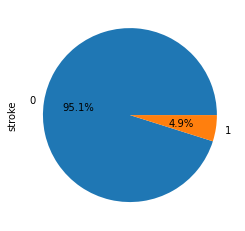

In [11]:
data.stroke.value_counts().plot.pie(autopct="%.1f%%");

Studiamo ora la distribuzione delle feature principali rappresentandole per via grafica.

Rappresentiamo inizialmente in che modo malattie cardiache e ipertensione siano collegate alla possibilità di colpi apoplettici:

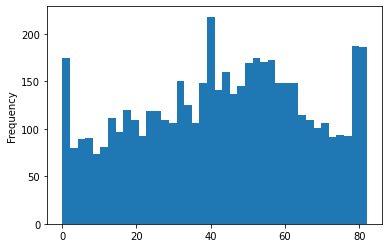

In [12]:
data.age.plot.hist(bins=40);

In [13]:
data["age"].describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

La distribuzione delle età degli individui sotto osservazione risulta abbastanza omogenea come si può notare dal grafico e dalla deviazione standard non troppo elevata.

Confrontiamo ora il sesso degli individui sotto esame:

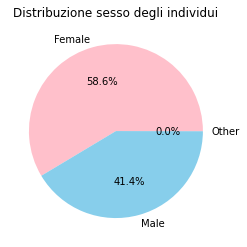

In [14]:
data.gender.value_counts().plot.pie(autopct="%.1f%%", colors= ["pink", "skyblue"]);
plt.title("Distribuzione sesso degli individui");
plt.ylabel("");

In [15]:
data.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Come si può notare la maggior parte degli individui sotto esame sono di sesso femminile. Notiamo anche la presenza di una terza categoria `Other` che in questo caso risulta poco significativa in quanto rappresentata da un'unica istanza.

Approfondiamo  visualizzando l'incidenza di ictus sui vari generi

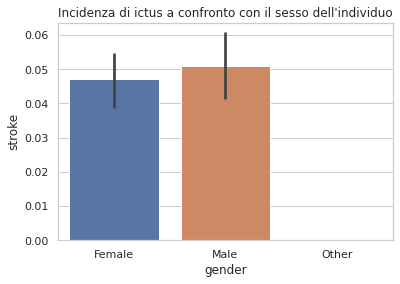

In [16]:
sns.set_theme(style="whitegrid")
plt.title("Incidenza di ictus a confronto con il sesso dell'individuo")
sns.barplot(x="gender", y="stroke", data=data);

Negli uomini l'incidenza di colpi apoplettici risulta maggiore rispetto alle donne. Si nota anche la presenza di un terzo valore `Other` con cardinalità molto bassa. Procediamo a rimuoverlo:

In [17]:
data = data[data.gender != "Other"]

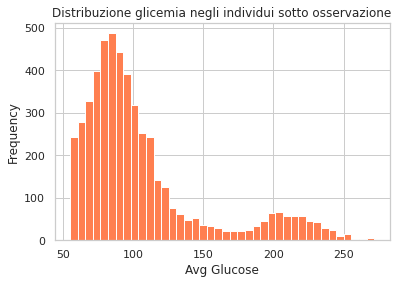

In [18]:
data.avg_glucose_level.plot.hist(bins=40, color="coral");
plt.title("Distribuzione glicemia negli individui sotto osservazione")
plt.xlabel("Avg Glucose");

In [19]:
data.avg_glucose_level.std()/data.avg_glucose_level.mean()

0.4266519060260945

La maggior parte degli individui in questione presenta un tasso di glicemia ordinario (ovvero compreso nell'intervallo tra i 70 e i 100 mg/dL) anche se la deviazione standard normalizzata non è indifferente in quanto ammonta circa a 0.42. 


Procediamo rappresentando come si correli il matrimonio all'incidenza di ictus:

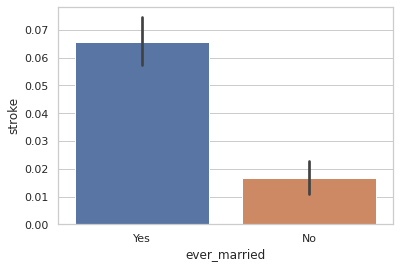

In [20]:
sns.barplot(x="ever_married", y="stroke", data=data);

Il grafico sembra suggerire che gli individui che si sono sposati siano maggiormente propensi a colpi apoplettici, tuttavia ciò non risulta vero in quanto gli individui sposati sono statisticamente più rappresentati rispetto agli scapoli:

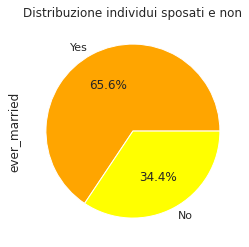

In [21]:
data.ever_married.value_counts().plot.pie(autopct="%.1f%%", colors= ["orange", "yellow"]);
plt.title("Distribuzione individui sposati e non");

Inoltre come viene citato nel seguente articolo https://www.reuters.com/article/us-health-marriage-idUSKBN1JE2XG , "People who are married may be less likely to develop cardiovascular disease or die from a heart attack or stroke than individuals who aren't, a research review suggests".

Questo suggerisce che lo sbilanciamento dei dati di questa feature sia appunto potenzialmente dannoso per l'accuratezza del nostro modello. Conviene quindi eliminarla dal Dataframe:

In [22]:
data.drop(columns=["ever_married"], inplace=True)

Elaboriamo adesso i dati inerenti il BMI (o *Body Mass Index*):

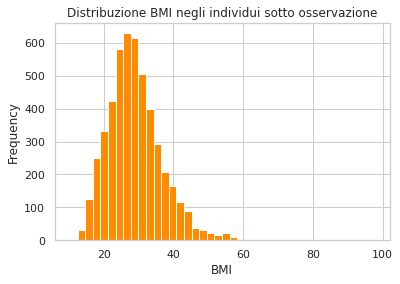

In [23]:
data.bmi.plot.hist(bins=40, color="darkorange");
plt.title("Distribuzione BMI negli individui sotto osservazione")
plt.xlabel("BMI");

L'indice di massa corporea come si nota presenta una deviazione standard molto bassa in quanto la maggior parte degli individui presenta valori nell'intervallo tra `20` e `40`, dove `18.5-24,99` è la fascia in cui rientrano gli individui normopeso, mentre oltre questa fascia vi sono gli individui sovrappeso e obesi.

Rappresentazione tramite barplot di `Residence_Type` 
a confronto con `stroke`

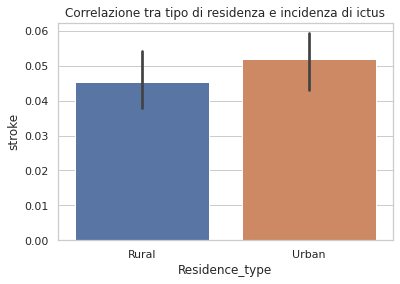

In [24]:
sns.set_theme(style="whitegrid")
plt.title("Correlazione tra tipo di residenza e incidenza di ictus")
sns.barplot(x="Residence_type", y="stroke", data=data);

Possiamo notare come i soggetti con residenza urbana siano statisticamente leggermente più soggetti alla possibilità di colpi apoplettici. Appare quindi che questa feature non sia indicativa nel rilevare la possibilità di ictus.

Mostriamo ora la correlazione che `hypertension` e `heart_disease` hanno con l'incidenza di ictus e come si correlano tra di loro:

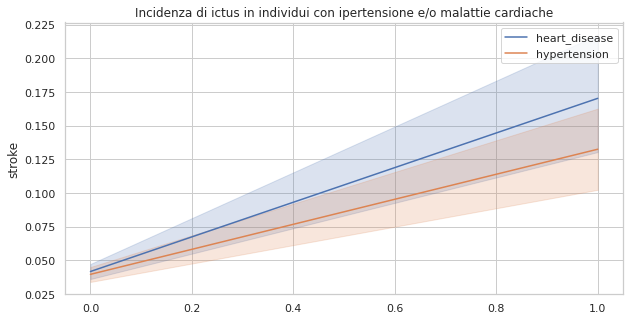

In [25]:
plt.figure(figsize=(10, 5))

sns.lineplot(x="heart_disease", y="stroke", label="heart_disease", data=data);
plt.legend()

sns.lineplot(x="hypertension", y="stroke", label="hypertension", data=data);
plt.legend()
plt.title("Incidenza di ictus in individui con ipertensione e/o malattie cardiache");
plt.xlabel("");

Dal grafico emerge ovviamente che queste sintomatologie influenzano la possibilità di colpi apoplettici (seppur non fortemente). Si palesa anche una certa correlazione tra le due feature `hypertension` e `heart_disease`. Esploreremo meglio questa correlazione in seguito usando la **regolarizzazione L1**.

Esploriamo la correlazione che invece con il tipo di lavoro che gli individui svolgono:

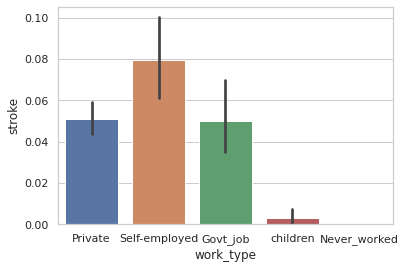

In [26]:
sns.barplot(x="work_type", y="stroke", data=data);

Gli individui che non hanno mai lavorato si rivelano, sorprendentemente, i meno propensi a colpi apoplettici, addirittura con meno episodi rispetto ai bambini. Probabilmente questa feature avrà una forte correlazione inversa con quella di ictus.

Ora rappresentiamo su barplot la correlazione tra ictus e stato di fumatore:

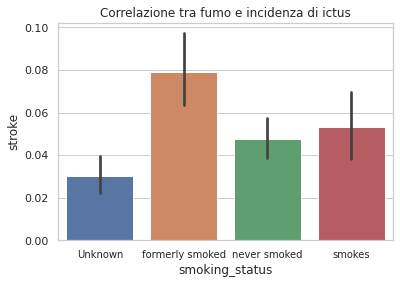

In [27]:
bars = sns.barplot(x="smoking_status", y="stroke", data=data)
plt.title("Correlazione tra fumo e incidenza di ictus")
bars.set_xticklabels(bars.get_xticklabels(), fontsize=10);

Dal grafico notiamo che gli individui che in passato erano fumatori hanno un'incidenza di colpi apoplettici di gran lunga maggiore rispetto a quella delle altre categorie in questione. Possiamo notare anche la presenza della colonna con valore `Unknown` che in questo caso risulta problematica nel corretto sviluppo del modello. Ce ne occuperemo nella fase di preparazione dei dati.

Approfondendo lo studio dei dati, plottiamo la matrice di correlazione delle feature numeriche del Dataframe:

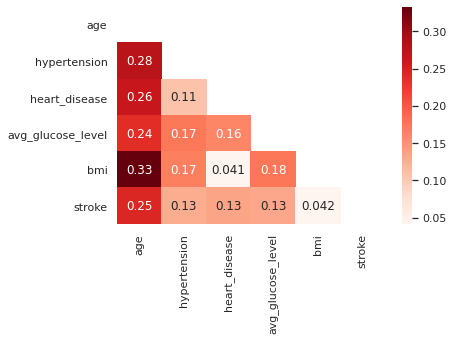

In [28]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap="Reds");

Notiamo come `age` sia molto correlata con tutte le feature e come tra le altre feature le correlazioni siano molto basse. D'altra parte `stroke` risulta influenzata in primis da `age` e di pari passo da `hypertension`, `heart_disease` e `avg_glucose_level` . Approfondiremo lo studio su quale feature siano più rilevanti in seguito. 

##Preparazione dei dati

###Elaborazione valori nulli

Andiamo ora a elaborare i dati presenti nel Dataframe affinchè vengano individuate le feature rilevanti ed ignorate quelle irrilevanti.

Iniziamo andando a visualizzare le righe del Dataframe che contengono valori nulli nelle colonne di tipo numerico:

In [29]:
data.shape[0]-data.count()

gender                 0
age                    0
hypertension           0
heart_disease          0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Notiamo la presenza di 201 righe con valore di `bmi` nullo. Procediamo rimuovendo queste righe:

In [30]:
data.dropna(inplace=True)
data.shape[0]-data.count()

gender               0
age                  0
hypertension         0
heart_disease        0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Nei dati della colonna `smoking_status` abbiamo notato la presenza dei valori `Unknown`. Andiamo a visualizzare effettivamente quanti dati presentano questo valore:


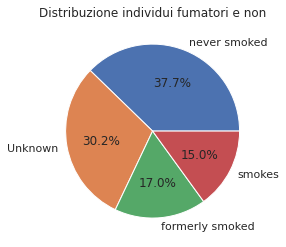

In [31]:
data.smoking_status.value_counts().plot.pie(autopct="%.1f%%");
plt.title("Distribuzione individui fumatori e non");
plt.ylabel("");

La colonna `Unknown` copre il `30.2%` delle istanze ed essendo questo valore non deducibile da altre colonne, conviene eliminare le righe con questo valore.

In [32]:
data = data[data.smoking_status != "Unknown"]

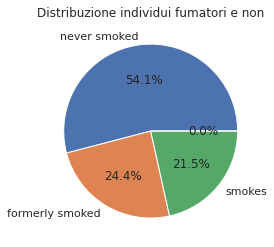

In [33]:
data.smoking_status.value_counts().plot.pie(autopct="%.1f%%");
plt.title("Distribuzione individui fumatori e non");
plt.ylabel("");

###Binarizzazione

Attualmente nel Dataframe attuale ci sono 4 variabili categoriche:
-   `gender`
-   `work_type`
- `Residence_type`
- `smoking_status`


Affinchè esse siano utilizzabili nel nostro modello è necessario che vengano mappate usando delle variabili binarie. Usiamo la funzione di binarizzazione 
`get_dummies()`:

In [34]:
data = pd.get_dummies(data, columns=["gender", "work_type", "Residence_type", "smoking_status"], prefix=["gender", "work", "Residence", "smoking"])

In [35]:
data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,Residence_Rural,Residence_Urban,smoking_Unknown,smoking_formerly smoked,smoking_never smoked,smoking_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0
2,80.0,0,1,105.92,32.5,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0
5,81.0,0,0,186.21,29.0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0


Procediamo rimuovendo le colonne associate ai valori non più presenti all'interno del Dataframe (`Other` e `Unknown`): 

In [36]:
data.drop(columns=["gender_Other", "smoking_Unknown"], inplace=True)

Il modello si presenta ora pronto alla fase successiva di preparazione.

##Preparazione del modello

###Standardizzazione, regolarizzazione e studio feature più importanti



Iniziamo importando le librerie necessarie:

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Dopodichè estraiamo dal Dataframe la variabile da prevedere (`stroke`) e il Dataframe costituito unicamente dalle altre variabili:

In [38]:
X = data.drop(columns="stroke")
y = data["stroke"]

Procediamo dunque suddividendo i dati in training e validation set tramite metodo **holdout**:

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

Eseguiamo adesso una prova usando i set appena creati per valutare un semplice modello basato su Perceptron:

In [40]:
model = Pipeline([
                  ("perc", Perceptron(n_jobs=-1, random_state=42))
])

In [41]:
model.fit(X_train, y_train)
print("R-squared coefficient:")
model.score(X_val, y_val)

R-squared coefficient:


0.9159369527145359

Il nostro modello, nonostante le variabili non siano normalizzate, produce già ottimi risultati con un tasso di accuratezza che arriva a `91,6 %` di accuratezza. Ciò accade perchè le variabili presenti non presentano ordini di grandezza troppo distanti.

Proviamo adesso a **standardizzare** le feature e vedere come ciò influisca sui nostri risultati:

In [42]:
std_model = Pipeline([
                      ("scaler", StandardScaler()),
                      ("perc", Perceptron(n_jobs=-1, random_state=42))
])

In [43]:
std_model.fit(X_train, y_train)
print("R-squared coefficient:")
std_model.score(X_val, y_val)

R-squared coefficient:


0.9369527145359019

Appare che standardizzando le feature il tasso di accuratezza, seppur di poco, salga ancora.
Proviamo adesso ad aggiungere una **regolarizzazione con norma L1** per individuare le feature più rilevanti e eliminare eventuali feature inutili:


In [44]:
std_l1_model = Pipeline([
                      ("scaler", StandardScaler()),
                      ("perc", Perceptron(penalty="l1", alpha=0.0001, n_jobs=-1, random_state=42))
])

In [45]:
std_l1_model.fit(X_train, y_train)
print("R-squared coefficient:")
std_l1_model.score(X_val, y_val)

R-squared coefficient:


0.936077057793345

In [46]:
col_coef = pd.DataFrame(std_l1_model.named_steps["perc"].coef_[0], columns=["coefficients"], index=X.columns)
col_coef

,coefficients
age,1.466258
hypertension,0.000000
heart_disease,-1.926350
avg_glucose_level,0.000000
bmi,0.000000
gender_Female,0.000000
gender_Male,0.000000
work_Govt_job,0.000000
work_Never_worked,-14.150164
work_Private,0.042962


In [47]:
col_coef[col_coef.coefficients == 0].size

10

Il modello ha una perdità di accuratezza infima e il peso di molte feature si annulla (si azzerano ben 10 feature su 17). Possiamo notare come emerga come feature più importante la colonna `work_Never_worked` che presenta un peso fortemente negativo. Possiamo anche notare come la feature `hypertension` si sia annullata a differenza di `heart_disease`risolvendo la presunta correlazione tra le due feature notata nel paragrafo di analisi dei dati.

Procediamo eliminando le feature non rilevanti:

In [48]:
data.drop(columns=col_coef[col_coef.coefficients == 0].index, inplace=True)

In [49]:
X = data.drop(columns="stroke")
y = data["stroke"]

E' importante notare come gli score di accuratezza sopra ottenuti non siano da ritenersi attendibili in quanto il dataset in uso presenta classi fortemente sbilanciate, comportando la generazione di un modello molto sbilanciato (risolveremo questa problematica nel paragrafo di modellazione), come si può notare dalla seguente matrice di confusione:

In [50]:
from sklearn.metrics import confusion_matrix

In [51]:
index = ["no stroke", "stroke"]
classes = ["no stroke[P]", "stroke[P]"]
pd.DataFrame(confusion_matrix(y_val, std_l1_model.predict(X_val)), columns=classes, index = index)

,no stroke[P],stroke[P]
no stroke,1068,11
stroke,62,1


##Modellazione
Partiamo importando le librerie che ci serviranno per la fase di modellazione:

In [52]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
import math
from sklearn import tree
import graphviz

Dato il forte sbilanciamento delle classi, è necessario ricorrere a una strategia di **oversampling** per fare in modo che il nostro modello non risulti troppo sbilanciato. In questo caso ricorriamo a **BorderlineSMOTE**, scelto dopo un testing fatto su SMOTE applicato a tutti i modelli sotto elencati. Altre tecniche in grado di risolvere tale problematica non verranno trattate nel seguente documento. Procediamo rinnovando training e validation set e facendo oversampling per compensare lo sbilanciamento:

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

In [54]:
sm = BorderlineSMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)

In [55]:
X_train_res.head()

,age,heart_disease,work_Never_worked,work_Private,work_children,smoking_never smoked,smoking_smokes
0,31.0,0.0,0.0,1.0,0.0,1.0,0.0
1,64.0,0.0,0.0,0.0,0.0,1.0,0.0
2,30.0,0.0,0.0,0.0,0.0,1.0,0.0
3,36.0,0.0,0.0,0.0,0.0,0.0,1.0
4,52.0,0.0,0.0,1.0,0.0,1.0,0.0


In [56]:
y_train_res.sum()

2166

Creaiamo dei dizionari per memorizzare i valori che otteremo dai modelli analizzati:


In [57]:
scores = {}
f1_scores = {}
precision = {}
recall = {}

###Perceptron

Iniziamo la fase di modellazione provando un modello basato su Perceptron, questa volta usando GridSearch per trovare i migliori parametri possibili. Analizziamo i seguenti iperparametri:
- standardizzazione o meno delle feature
- tipo di regolarizzazione del modello
- peso della regolarizzazione
- stima o meno dell'intercetta

In [58]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [59]:
perc_model = Pipeline([
    ("scaler", StandardScaler()),
    ("perc", Perceptron(n_jobs=-1, random_state=42))
])

#print(per_model.get_params())

perc_grid = {
    "scaler": [None, StandardScaler()],
    "perc__penalty": ["l2", "l1", "elasticnet"],
    "perc__alpha": np.logspace(-3, 3, 10),
    "perc__fit_intercept": [False, True]
}

In [60]:
%%time

perc_gv = GridSearchCV(perc_model, perc_grid, cv=kfold, n_jobs=-1)
perc_gv.fit(X_train_res, y_train_res)

CPU times: user 1.12 s, sys: 66.8 ms, total: 1.19 s
Wall time: 6.09 s


In [61]:
print("Punteggio migliore: {score}".format(score=perc_gv.score(X_val, y_val)));
print("F1 score: {score}".format(score=f1_score(y_val, perc_gv.predict(X_val), average="binary")));
print("Precision score: {score}".format(score=precision_score(y_val, perc_gv.predict(X_val))))
print("Recall score: {score}".format(score=recall_score(y_val, perc_gv.predict(X_val))))
print("Parametri migliori: {params}".format(params=perc_gv.best_params_))

scores["perc"] = perc_gv.score(X_val, y_val);
f1_scores["perc"] = f1_score(y_val, perc_gv.predict(X_val), average="binary")
precision["perc"] = precision_score(y_val, perc_gv.predict(X_val))
recall["perc"] = recall_score(y_val, perc_gv.predict(X_val))

Punteggio migliore: 0.7110332749562172
F1 score: 0.23255813953488372
Precision score: 0.1362397820163488
Recall score: 0.7936507936507936
Parametri migliori: {'perc__alpha': 0.001, 'perc__fit_intercept': False, 'perc__penalty': 'l1', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [92]:
index = ["no stroke", "stroke"]
classes = ["no stroke[P]", "stroke[P]"]
perc_conf = pd.DataFrame(confusion_matrix(y, perc_gv.predict(X)), columns=classes, index = index)
perc_conf

,no stroke[P],stroke[P]
no stroke,2268,977
stroke,43,137


Come era prevedibile l'uso di SMOTE ha comportato una significativa riduzione del tasso di accuratezza. Dalla matrice di confusione si nota che il modello appare ancora piuttosto sbilanciato. Procediamo a migliorarlo usando la **Regressione Logistica**.

###Regressione Logistica

Iniziamo la fase di modellazione provando un modello di Regressione Logistica con scelti dei migliori parametri tramite uso di GridSearch, con test sui seguenti parametri:
- standardizzazione o meno delle feature
- tipo di regolarizzazione del modello

In [63]:
log_model = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(solver='saga', random_state=42))
])

log_grid = {
    "scaler": [None, StandardScaler()],
    "log_reg__penalty": ["l2", "l1"],
    "log_reg__C": np.logspace(-3, 3, 10),
    "log_reg__fit_intercept": [False, True]
}

In [64]:
%%time

log_gv = GridSearchCV(log_model, log_grid, cv=kfold, n_jobs=-1)
log_gv.fit(X_train_res, y_train_res)

CPU times: user 843 ms, sys: 31.5 ms, total: 874 ms
Wall time: 15.5 s


In [65]:
print("Punteggio migliore: {score}".format(score=log_gv.score(X_val, y_val)));
print("F1 score: {score}".format(score=f1_score(y_val, log_gv.predict(X_val), average="binary")));
print("Precision score: {score}".format(score=precision_score(y_val, log_gv.predict(X_val))))
print("Recall score: {score}".format(score=recall_score(y_val, log_gv.predict(X_val))))
print("Parametri migliori: {params}".format(params=log_gv.best_params_))

scores["log"] = log_gv.score(X_val, y_val);
f1_scores["log"] = f1_score(y_val, log_gv.predict(X_val), average="binary")
precision["log"] = precision_score(y_val, log_gv.predict(X_val))
recall["log"] = recall_score(y_val, log_gv.predict(X_val))

Punteggio migliore: 0.7171628721541156
F1 score: 0.2327790973871734
Precision score: 0.13687150837988826
Recall score: 0.7777777777777778
Parametri migliori: {'log_reg__C': 0.021544346900318832, 'log_reg__fit_intercept': True, 'log_reg__penalty': 'l1', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [91]:
log_conf = pd.DataFrame(confusion_matrix(y, log_gv.predict(X)), columns=classes, index = index)
log_conf

,no stroke[P],stroke[P]
no stroke,2333,912
stroke,39,141


Il tasso di accuratezza si abbassa ancora ma ciononostante la matrice di confusione indica che abbiamo un netto miglioramento nelle capacità predittiva del modello che adesso risulta notevolmente più affidabile (specialmente nel caso di falsi negativi) rispetto al modello basato su **Perceptron**. D'altra parte il tasso di falsi positivi è ancora molto alto. Proviamo in seguito una modellazione tramite **Support Vector Machines**.

###SVM

In [67]:
svc_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", LinearSVC(dual=False, random_state=42))
])

svc_grid = {
    "scaler": [None, StandardScaler()],
    "svc__penalty": ["l2", "l1"],
    "svc__loss": ["hinge", "squared_hinge"],
    "svc__fit_intercept": [False, True],
    "svc__class_weight": [None, "balanced"],
    "svc__C": np.logspace(-3, 3, 10)
}

In [68]:
%%time

svc_gv = GridSearchCV(svc_model, svc_grid, cv=kfold, n_jobs=-1)
svc_gv.fit(X_train_res, y_train_res)

CPU times: user 2.33 s, sys: 50.2 ms, total: 2.38 s
Wall time: 9.92 s


In [69]:
print("Punteggio migliore: {score}".format(score=svc_gv.score(X_val, y_val)));
print("F1 score: {score}".format(score=f1_score(y_val, svc_gv.predict(X_val), average="binary")));
print("Precision score: {score}".format(score=precision_score(y_val, svc_gv.predict(X_val))))
print("Recall score: {score}".format(score=recall_score(y_val, svc_gv.predict(X_val))))
print("Parametri migliori: {params}".format(params=svc_gv.best_params_))

scores["svc"] = svc_gv.score(X_val, y_val);
f1_scores["svc"] = f1_score(y_val, svc_gv.predict(X_val), average="binary")
precision["svc"] = precision_score(y_val, svc_gv.predict(X_val))
recall["svc"] = recall_score(y_val, svc_gv.predict(X_val))

Punteggio migliore: 0.7092819614711033
F1 score: 0.22790697674418606
Precision score: 0.1335149863760218
Recall score: 0.7777777777777778
Parametri migliori: {'scaler': None, 'svc__C': 0.46415888336127775, 'svc__class_weight': 'balanced', 'svc__fit_intercept': True, 'svc__loss': 'squared_hinge', 'svc__penalty': 'l1'}


In [93]:
svc_conf = pd.DataFrame(confusion_matrix(y, svc_gv.predict(X)), columns=classes, index = index)
svc_conf

,no stroke[P],stroke[P]
no stroke,2303,942
stroke,40,140


###Decision Tree

Usiamo adesso un modello basato su **Albero di Regressione**, strutturato nel seguente modo:
- ogni nodo contiene un predicato che a sua volta divide le istanze in input in 2 sottoinsiemi e cosi via ricorsivamente
- ogni nodo foglia rappresenta la classificazione attuata sulle istanze che hanno soddisfatto tutti i predicati precedenti

Procediamo all'addestramento:

In [71]:
num_features = X.columns.size

tree_model = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])

#print(tree_model.get_params())

tree_grid = {'scaler': [None, StandardScaler()],
             'tree__min_samples_split': range(2, 6),
             'tree__min_samples_leaf': range(1, 6), 
             'tree__max_depth': range(2,6),
             'tree__max_features': range(2, num_features)}

In [72]:
%%time

tree_gv = GridSearchCV(tree_model, tree_grid, cv=kfold, n_jobs=-1)
tree_gv.fit(X_train_res, y_train_res)

CPU times: user 5.31 s, sys: 101 ms, total: 5.41 s
Wall time: 24 s


In [73]:
print("Punteggio migliore: {score}".format(score=tree_gv.score(X_val, y_val)));
print("F1 score: {score}".format(score=f1_score(y_val, tree_gv.predict(X_val), average="binary")));
print("Precision score: {score}".format(score=precision_score(y_val, tree_gv.predict(X_val))))
print("Recall score: {score}".format(score=recall_score(y_val, tree_gv.predict(X_val))))
print("Parametri migliori: {params}".format(params=tree_gv.best_params_))

scores["tree"] = tree_gv.score(X_val, y_val);
f1_scores["tree"] = f1_score(y_val, tree_gv.predict(X_val), average="binary")
precision["tree"] = precision_score(y_val, tree_gv.predict(X_val))
recall["tree"] = recall_score(y_val, tree_gv.predict(X_val))

Punteggio migliore: 0.8966725043782837
F1 score: 0.20270270270270274
Precision score: 0.17647058823529413
Recall score: 0.23809523809523808
Parametri migliori: {'scaler': None, 'tree__max_depth': 5, 'tree__max_features': 3, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}


Il modello ottiene i valori migliori rispetto ai modelli precedenti con un tasso di accuratezza di gran lunga maggiore come possiamo notare dalla seguente tabella di confronto:

Tuttavia per ottenere una stima valida, osserviamo la matrice di confusione di questo modello:

In [94]:
tree_conf = pd.DataFrame(confusion_matrix(y, tree_gv.predict(X)), columns=classes, index = index)
tree_conf

,no stroke[P],stroke[P]
no stroke,3049,196
stroke,129,51


Il modello, nonostante l'uso di BorderlineSmote, risulta fortemente sbilanciato e presenta un forte numero di falsi negativi. Questo implica che in questo caso i valori di coefficiente di correlazione e F1 Score non siano attendibili nel descrivere l'affidabilità del modello e che il modello sia probabilmente in **overfitting**.

### Random Forest

In [75]:
forest_model = Pipeline([
    ("scaler", StandardScaler()),
    ("forest", RandomForestClassifier(n_jobs=-1, random_state=42))
])

forest_grid = {"scaler": [None, StandardScaler()],
             'forest__n_estimators': range(5, 10),
             'forest__min_samples_split': range(2, 5), 
             'forest__max_depth': [None] + [i for i in range(1, 3)],
             'forest__max_features': [int(math.sqrt(num_features)), num_features - 1]}

In [76]:
%%time

forest_gv = GridSearchCV(forest_model, forest_grid, cv=kfold, n_jobs=-1)
forest_gv.fit(X_train_res, y_train_res)

CPU times: user 5.15 s, sys: 252 ms, total: 5.4 s
Wall time: 1min 37s


In [77]:
print("Punteggio migliore: {score}".format(score=forest_gv.score(X_val, y_val)));
print("Precision score: {score}".format(score=precision_score(y_val, forest_gv.predict(X_val))))
print("Recall score: {score}".format(score=recall_score(y_val, forest_gv.predict(X_val))))
print("Parametri migliori: {params}".format(params=forest_gv.best_params_))

scores["forest"] = forest_gv.score(X_val, y_val);
f1_scores["forest"] = f1_score(y_val, forest_gv.predict(X_val), average="binary")
precision["forest"] = precision_score(y_val, forest_gv.predict(X_val))
recall["forest"] = recall_score(y_val, forest_gv.predict(X_val))

Punteggio migliore: 0.8922942206654991
Precision score: 0.13414634146341464
Recall score: 0.1746031746031746
Parametri migliori: {'forest__max_depth': None, 'forest__max_features': 2, 'forest__min_samples_split': 3, 'forest__n_estimators': 5, 'scaler': None}


In [95]:
forest_conf = pd.DataFrame(confusion_matrix(y, forest_gv.predict(X)), columns=classes, index = index)
forest_conf

,no stroke[P],stroke[P]
no stroke,3075,170
stroke,107,73


Il modello `RandomForestClassifier` si comporta infine in maniera molto simile al `DecisionTreeClassifier`, come era prevedibile essendo una Random Forest un insieme di Decision Tree.


##Valutazione dei vari modelli utilizzati

Confrontiamo adesso i vari modelli e i valori ottenuti da ciascuno di essi.
Analizziamo **coefficiente R^2** e **F1 score**:

In [79]:
pd.DataFrame.from_dict(scores, orient="index", columns=["R^2 score"])

,R^2 score
perc,0.711033
log,0.717163
svc,0.709282
tree,0.896673
forest,0.892294


In [80]:
pd.DataFrame.from_dict(f1_scores, orient="index", columns=["F1 score"])

,F1 score
perc,0.232558
log,0.232779
svc,0.227907
tree,0.202703
forest,0.151724


In [81]:
pd.DataFrame.from_dict(precision, orient="index", columns=["Precision score"])

,Precision score
perc,0.136240
log,0.136872
svc,0.133515
tree,0.176471
forest,0.134146


In [82]:
pd.DataFrame.from_dict(recall, orient="index", columns=["Recall score"])

,Recall score
perc,0.793651
log,0.777778
svc,0.777778
tree,0.238095
forest,0.174603


Guardando le tabelle emerge che i modelli basati su `DecisionTreeClassifier` e `RandomForestClassifier` hanno score di determinazione e F1 score più alti rispetto agli altri modelli, tuttavia, essendo l'ambito medico il contesto di utilizzo, è più opportuno basare il nostro giudizio sul **Recall score** (ovvero i veri casi di ictus classificati correttamente).
Ciò emerge anche dalle matrici di confusione dei vari modelli:

In [96]:
print("Perceptron")
print(perc_conf)
print("\n")
print("Logistic Regression")
print(log_conf)
print("\n")
print("Support Vector Machines")
print(svc_conf)
print("\n")
print("Decision Tree")
print(tree_conf)
print("\n")
print("Random Forest")
print(forest_conf)

Perceptron
           no stroke[P]  stroke[P]
no stroke          2268        977
stroke               43        137


Logistic Regression
           no stroke[P]  stroke[P]
no stroke          2333        912
stroke               39        141


Support Vector Machines
           no stroke[P]  stroke[P]
no stroke          2303        942
stroke               40        140


Decision Tree
           no stroke[P]  stroke[P]
no stroke          3049        196
stroke              129         51


Random Forest
           no stroke[P]  stroke[P]
no stroke          3075        170
stroke              107         73


##Confronto modelli con intervallo di confidenza


Effettuiamo adesso il confronto con intervallo di confidenza al 95% per constatare quanto siano affidabili i nostri modelli migliori (`Perceptron`, `LogisticRegression` e `SVM`):

In [84]:
def confidence(acc, N, Z):
    den = (2*(N+Z**2))
    var = (Z*np.sqrt(Z**2+4*N*acc-4*N*acc**2)) / den
    a = (2*N*acc+Z**2) / den
    inf = a - var
    sup = a + var
    return (inf, sup)

def calculate_accuracy(conf_matrix):
    return np.diag(conf_matrix).sum() / conf_matrix.sum().sum()

In [85]:
pd.DataFrame([confidence(calculate_accuracy(perc_conf), len(X_val), 1.96),
              confidence(calculate_accuracy(log_conf), len(X_val), 1.96),
              confidence(calculate_accuracy(svc_conf), len(X_val), 1.96)],
                 index=["perceptron", "logistic reg", "SVM"], columns=["inf", "sup"])

,inf,sup
perceptron,0.684070,0.736581
logistic reg,0.690347,0.742523
SVM,0.682278,0.734883


Come si poteva anche notare dai punteggi di recall precedentemente mostrati e dalle matrici di confusione, il modello basato su Regressione Logistica risulta il più accurato.

##Confronto con un modello casuale

Addestriamo adesso un modello casuale e valutiamo come esso performa sui nostri dati:

In [86]:
from sklearn.dummy import DummyClassifier

In [87]:
random = DummyClassifier(strategy="uniform", random_state=42)
random.fit(X_train_res, y_train_res)

random_score = random.score(X_val, y_val)

print("Score: {score}".format(score=random_score));
print("F1 score: {score}".format(score=f1_score(y_val, random.predict(X_val))));
print("Precision score: {score}".format(score=precision_score(y_val, random.predict(X_val))))
print("Recall score: {score}".format(score=recall_score(y_val, random.predict(X_val))))

scores["random"] = random.score(X_val, y_val);
f1_scores["random"] = f1_score(y_val, random.predict(X_val), average="binary")
precision["random"] = precision_score(y_val, random.predict(X_val))
recall["random"] = recall_score(y_val, random.predict(X_val))

Score: 0.5026269702276708
F1 score: 0.10410094637223975
Precision score: 0.05779334500875657
Recall score: 0.5238095238095238


In [97]:
random_conf = pd.DataFrame(confusion_matrix(y, random.predict(X)), columns=classes, index = index)
random_conf

,no stroke[P],stroke[P]
no stroke,1629,1616
stroke,86,94


Ovviamente i punteggi ottenuti non sono paragonabili a quelli dei modelli precedentemente addestrati.
Procediamo confrontando il modello casuale con il modello basato su Regressione Logistica:

In [89]:
from scipy import stats

def difference_between_two_models(error1, error2, confidence):
    z_half_alfa = stats.norm.ppf(confidence)
    variance = (((1 - error1) * error1) / len(y_val)) + (((1 - error2) * error2) / len(y_val))
    d_minus = abs(error1 - error2) - z_half_alfa * (pow(variance, 0.5))
    d_plus = abs(error1 - error2) + z_half_alfa * (pow(variance, 0.5))
    print("Valore minimo: {}\nValore massimo: {}\n".format(d_minus, d_plus))

In [90]:
difference_between_two_models(1 - f1_scores["log"], 1 - f1_scores["random"], 0.99)

Valore minimo: 0.09278498157235394
Valore massimo: 0.16457132045751333



##Conclusioni
Considerando i valori ottenuti dal modello, specialmente facendo riferimento allo score di recall ottenuto, mi reputo personalmente soddisfatto del lavoro svolto, poichè seppur l'F1 score ottenuto non sia molto alto rispetto a quello di altri progetti presenti su Kaggle (diversi modelli non bilanciavano correttamente la distribuzione delle classi, da qui score estremamente alti), il modello si rivela solido. Ovviamente il modello non può rimpiazzare il giudizio di un medico ma può essere un buono strumento per analizzare e valutare le condizioni di salute di un individuo rispetto alla possibilità di colpi apoplettici